# Background

Portfolio analysis

- Analyze adjusted closing price to account for cash and stock dividends

# Import Libraries & Data

In [44]:
import yfinance as yf
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.plotting import plot_efficient_frontier


import pandas as pd
import numpy as np
import time

In [30]:
# tickers = ['TSLA', 'ARKK', 'AAPL', 'BTC-USD']
tickers = ['TSLA', 'GOOG', 'AAPL',]

df = pd.DataFrame()
for ticker in tickers:
    # download adjusted closing prices from yahoo finance
    data = yf.download(ticker,'2016-01-01','2020-11-01')['Adj Close']
    df[f'{ticker}_adj_close'] = data


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [31]:
df.head()

,TSLA_adj_close,GOOG_adj_close,AAPL_adj_close
Date,,,
2016-01-04,44.681999,741.840027,24.443037
2016-01-05,44.686001,742.580017,23.830513
2016-01-06,43.807999,743.619995,23.364161
2016-01-07,43.130001,726.390015,22.378082
2016-01-08,42.200001,714.469971,22.496408


In [32]:
mu = mean_historical_return(df)
S = CovarianceShrinkage(df).ledoit_wolf()

In [33]:
mu

TSLA_adj_close    0.565101
GOOG_adj_close    0.175850
AAPL_adj_close    0.362816
dtype: float64

In [35]:
S

,TSLA_adj_close,GOOG_adj_close,AAPL_adj_close
TSLA_adj_close,0.328282,0.056001,0.068191
GOOG_adj_close,0.056001,0.071966,0.051761
AAPL_adj_close,0.068191,0.051761,0.092754


In [37]:
ef = EfficientFrontier(mu, S)
weights = ef.max_sharpe()

In [43]:
plt.show(ef)

In [39]:
cleaned_weights = ef.clean_weights()
ef.save_weights_to_file("weights.txt")  # saves to file
print(cleaned_weights)

OrderedDict([('TSLA_adj_close', 0.26507), ('GOOG_adj_close', 0.0), ('AAPL_adj_close', 0.73493)])


In [40]:
ef.portfolio_performance(verbose=True)

Expected annual return: 41.6%
Annual volatility: 31.6%
Sharpe Ratio: 1.26


(0.4164352565598268, 0.3158041411609302, 1.2553200065790395)

<AxesSubplot:xlabel='Date'>

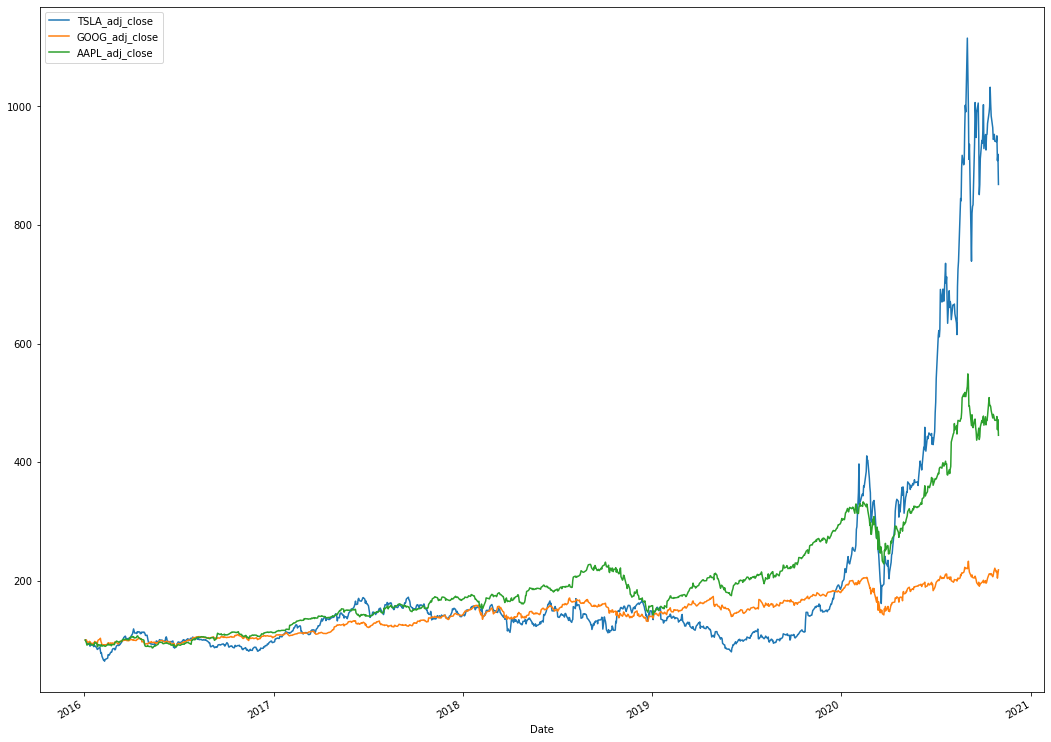

In [5]:
import matplotlib.pyplot as plt
(df/df.iloc[0]*100).plot(figsize=(18,14))

In [6]:
# average daily returns
returns = np.log(df/df.shift(1))
returns.mean()

TSLA_adj_close    0.001778
GOOG_adj_close    0.000643
AAPL_adj_close    0.001228
dtype: float64

In [7]:
# average annualized returns
returns.mean() * 252

TSLA_adj_close    0.447950
GOOG_adj_close    0.161991
AAPL_adj_close    0.309553
dtype: float64

In [8]:
# annualize covariance matrix
returns.cov() * 252

,TSLA_adj_close,GOOG_adj_close,AAPL_adj_close
TSLA_adj_close,0.331117,0.058315,0.071110
GOOG_adj_close,0.058315,0.070567,0.053270
AAPL_adj_close,0.071110,0.053270,0.091723


In [9]:
# randomly generate list of weights that sum to 1
num_assets = len(tickers)
weights = np.random.dirichlet(np.ones(num_assets), size=1)
weights = weights[0]
print(weights)

[0.26960238 0.24703068 0.48336694]


In [10]:
# calculate expected weighted return of the portfolio of assets
exp_port_return = np.sum(returns.mean()*weights)*252
print(exp_port_return)

0.3104130198211541


In [11]:
# generate the portfolio mean return and portfolio volatility for one set of randomly selected weights.
port_var = np.dot(weights.T, np.dot(returns.cov()*252, weights))
port_vol = np.sqrt(port_var)
print(port_var)
print(port_vol)

0.08882714996294457
0.29803883968862943


# Markowitz Bullet Plot

In [12]:
import numpy as np
import time

def portfolio_simulation(assets, iterations):
    '''
    Runs a simulation by randomly selecting portfolio weights a specified
    number of times (iterations), returns the list of results and plots 
    all the portfolios as well.
    
    Parameters:
    -----------  
        assets: list
            all the assets that are to be pulled from Quandl to comprise
            our portfolio.    
        iterations: int 
            the number of randomly generated portfolios to build.
    
    Returns:
    --------
        port_returns: array
            array of all the simulated portfolio returns.
        port_vols: array
            array of all the simulated portfolio volatilities.
    '''
    
    start = time.time()
    num_assets = len(assets)
    
    # Fetch data    
    adj_closes = pd.DataFrame()
    for ticker in tickers:
        # download adjusted closing prices from yahoo finance
        data = yf.download(ticker,'2016-01-01','2020-11-01')['Adj Close']
        adj_closes[f'{ticker}_adj_close'] = data
    returns = np.log(adj_closes / adj_closes.shift(1))
    
    port_returns = []
    port_vols = []
    
    for i in range (iterations):
        weights = np.random.dirichlet(np.ones(num_assets),size=1)
        weights = weights[0]
        port_returns.append(np.sum(returns.mean() * weights) * 252)
        port_vols.append(np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights))))
    
    # Convert lists to arrays
    port_returns = np.array(port_returns)
    port_vols = np.array(port_vols)
 
    
    # Plot the distribution of portfolio returns and volatilities 
    plt.figure(figsize = (18,10))
    plt.scatter(port_vols,port_returns,c = (port_returns / port_vols), marker='o')
    plt.xlabel('Portfolio Volatility')
    plt.ylabel('Portfolio Return')
    plt.colorbar(label = 'Sharpe ratio (not adjusted for short rate)')
    
    print('Elapsed Time: %.2f seconds' % (time.time() - start))
    
    return weights, port_returns, port_vols

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Elapsed Time: 2.96 seconds


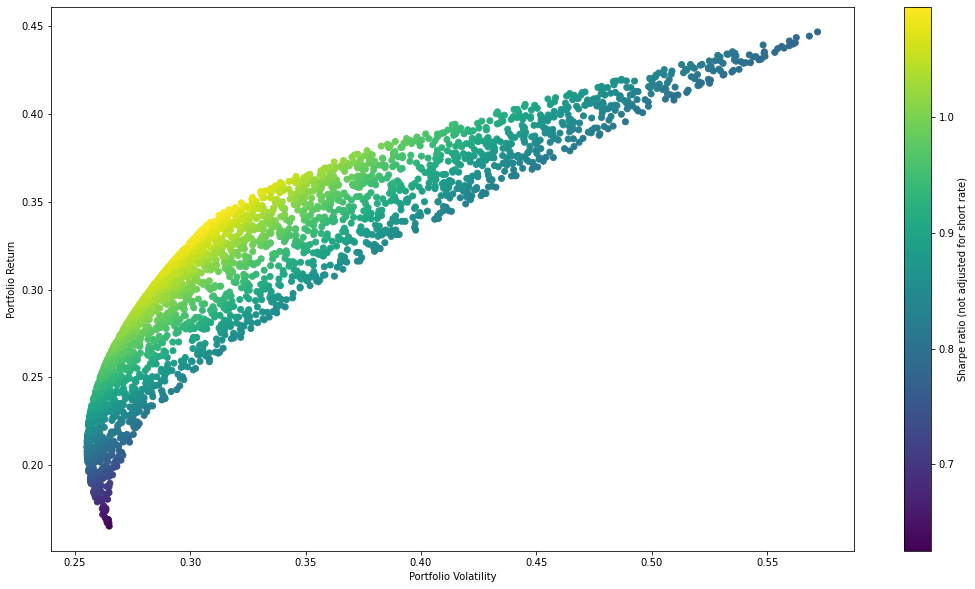

In [13]:
assets = ['TSLA', 'GOOG', 'AAPL',]
# assets = ['TSLA', 'ARKK', 'AAPL', 'BTC-USD']
weights, port_returns, port_vols = portfolio_simulation(assets, 3000)

In [14]:
weights

array([0.0219626 , 0.06233453, 0.91570287])

In [15]:
port_returns

array([0.17965415, 0.35819033, 0.23232955, ..., 0.30867616, 0.30896799,
       0.30339459])

# Optimization

In [16]:
def portfolio_stats(weights):
    global returns
    '''
    We can gather the portfolio performance metrics for a specific set of weights.
    This function will be important because we'll want to pass it to an optmization
    function to get the portfolio with the best desired characteristics.
    
    Note: Sharpe ratio here uses a risk-free short rate of 0.
    
    Paramaters: 
    -----------
        weights: array, 
            asset weights in the portfolio.
        returns: dataframe
            a dataframe of returns for each asset in the trial portfolio    
    
    Returns: 
    --------
        dict of portfolio statistics - mean return, volatility, sharp ratio.
    '''

    # Convert to array in case list was passed instead.
    weights = np.array(weights)
    port_return = np.sum(returns.mean() * weights) * 252
    port_vol = np.sqrt(np.dot(weights.T, np.dot(returns.cov() * 252, weights)))
    sharpe = port_return/port_vol

    return {'return': port_return, 'volatility': port_vol, 'sharpe': sharpe}

def minimize_sharpe(weights):  
    return -portfolio_stats(weights)['sharpe'] 

def minimize_volatility(weights):  
    # Note that we don't return the negative of volatility here because we 
    # want the absolute value of volatility to shrink, unlike sharpe.
    return portfolio_stats(weights)['volatility'] 

def minimize_return(weights): 
    return -portfolio_stats(weights)['return']

## Maximize Sharpe

In [17]:
constraints = ({'type' : 'eq', 'fun': lambda x: np.sum(x) -1})
bounds = tuple((0,1) for x in range(num_assets))
initializer = (num_assets * [1./num_assets,])

print (initializer)
print (bounds)

[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
((0, 1), (0, 1), (0, 1))


In [18]:
import scipy.optimize as optimize
optimal_sharpe = optimize.minimize(minimize_sharpe,
                                 initializer,
                                 method = 'SLSQP',
                                 bounds = bounds,
                                 constraints = constraints)
print(optimal_sharpe)

     fun: -1.0960854505119506
     jac: array([ 7.50869513e-05,  9.89706814e-02, -2.02506781e-05])
 message: 'Optimization terminated successfully'
    nfev: 20
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([0.21263903, 0.        , 0.78736097])


In [19]:
optimal_sharpe_weights=optimal_sharpe['x'].round(4)
list(zip(assets,list(optimal_sharpe_weights)))

[('TSLA', 0.2126), ('GOOG', 0.0), ('AAPL', 0.7874)]

In [20]:
optimal_stats = portfolio_stats(optimal_sharpe_weights)
print(optimal_stats)

print('Optimal Portfolio Return: ', round(optimal_stats['return']*100,4))
print('Optimal Portfolio Volatility: ', round(optimal_stats['volatility']*100,4))
print('Optimal Portfolio Sharpe Ratio: ', round(optimal_stats['sharpe'],4))

{'return': 0.33897645249736724, 'volatility': 0.30926097221978377, 'sharpe': 1.0960854519220273}
Optimal Portfolio Return:  33.8976
Optimal Portfolio Volatility:  30.9261
Optimal Portfolio Sharpe Ratio:  1.0961


## Minimize Volatility

In [21]:
optimal_variance=optimize.minimize(minimize_volatility,
                                   initializer,
                                   method = 'SLSQP',
                                   bounds = bounds,
                                   constraints = constraints)

print(optimal_variance)
optimal_variance_weights=optimal_variance['x'].round(4)
list(zip(assets,list(optimal_variance_weights)))

     fun: 0.2552818602382945
     jac: array([0.25533069, 0.25530983, 0.25521706])
 message: 'Optimization terminated successfully'
    nfev: 24
     nit: 6
    njev: 6
  status: 0
 success: True
       x: array([0.01091367, 0.68514597, 0.30394037])


[('TSLA', 0.0109), ('GOOG', 0.6851), ('AAPL', 0.3039)]

In [22]:
# Make an array of 50 returns betweeb the minimum return and maximum return
# discovered earlier.
target_returns = np.linspace(port_returns.min(),port_returns.max(),50)

# Initialize optimization parameters
minimal_volatilities = []
bounds = tuple((0,1) for x in weights)
initializer = num_assets * [1./num_assets,]

for target_return in target_returns:
    
    constraints = ({'type':'eq','fun': lambda x: portfolio_stats(x)['return']-target_return},
                   {'type':'eq','fun': lambda x: np.sum(x)-1})
       
    optimal = optimize.minimize(minimize_volatility,
                              initializer,
                              method = 'SLSQP',
                              bounds = bounds,
                              constraints = constraints)
    
    minimal_volatilities.append(optimal['fun'])

minimal_volatilities = np.array(minimal_volatilities)

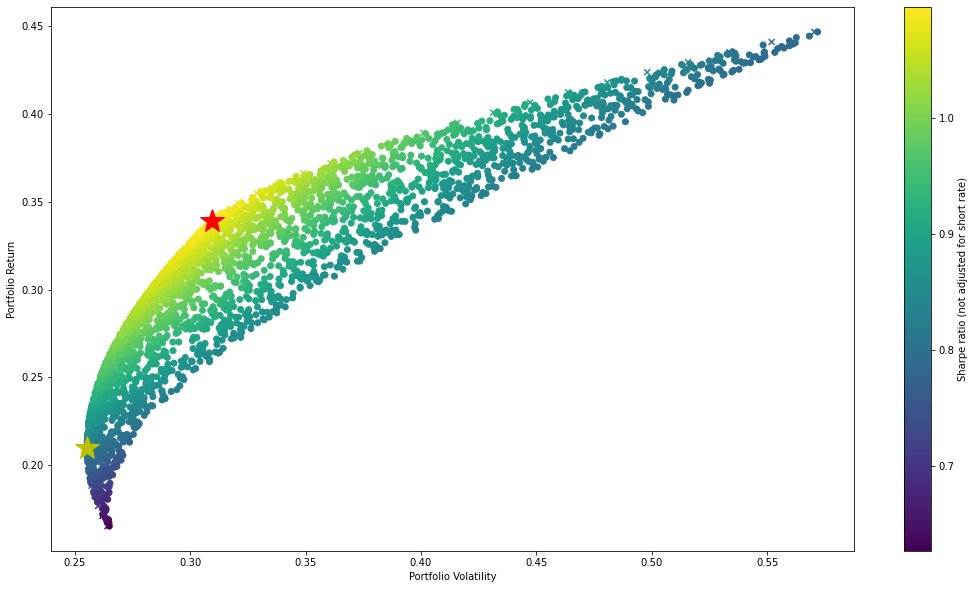

In [23]:
import matplotlib.pyplot as plt 

# initialize figure size
plt.figure(figsize=(18,10))

plt.scatter(port_vols,
            port_returns,
            c = (port_returns / port_vols),
            marker = 'o')

plt.scatter(minimal_volatilities,
            target_returns,
            c = (target_returns / minimal_volatilities),
            marker = 'x')

plt.plot(portfolio_stats(optimal_sharpe_weights)['volatility'],
         portfolio_stats(optimal_sharpe_weights)['return'],
         'r*',
         markersize = 25.0)

plt.plot(portfolio_stats(optimal_variance_weights)['volatility'],
         portfolio_stats(optimal_variance_weights)['return'],
         'y*',
         markersize = 25.0)

plt.xlabel('Portfolio Volatility')
plt.ylabel('Portfolio Return')
plt.colorbar(label='Sharpe ratio (not adjusted for short rate)')

# Capital Market Line

In [24]:
import scipy.interpolate as sci

min_index = np.argmin(minimal_volatilities)
ex_returns = target_returns[min_index:]
ex_volatilities = minimal_volatilities[min_index:]

var = sci.splrep(ex_returns, ex_volatilities)

def func(x):
    # Spline approximation of the efficient frontier
    spline_approx = sci.splev(x,var,der=0)  
    return spline_approx

def d_func(x):
    # first derivative of the approximate efficient frontier function
    deriv = sci.splev(x,var,der=1)
    return deriv

def eqs(p, rfr = 0.01):

    #rfr = risk free rate
    
    eq1 = rfr - p[0]
    eq2 = rfr + p[1] * p[2] - func(p[2])
    eq3=p[1] - d_func(p[2]) 
    return eq1, eq2, eq3

# Initializing the weights can be tricky - I find taking the half-way point between your max return and max
# variance typically yields good results.

rfr = 0.01
m=  port_vols.max() / 2
l = port_returns.max() / 2

# optimal = optimize.fsolve(eqs, [rfr,m,l])
optimal = optimize.fsolve(eqs, [0.01, 0.5, 0.15])
# Create input variable for CML
print(optimal)

[0.01       0.88280727 0.33832593]


In [27]:
x_lower = min(ex_volatilities)
x_upper = max(ex_volatilities)
x_range = np.linspace(x_lower, x_upper, 700)
tck = sci.splrep(ex_volatilities, ex_returns)
bspline = sci.splev(x_range, tck)
cx = np.linspace(0.0, 0.6)


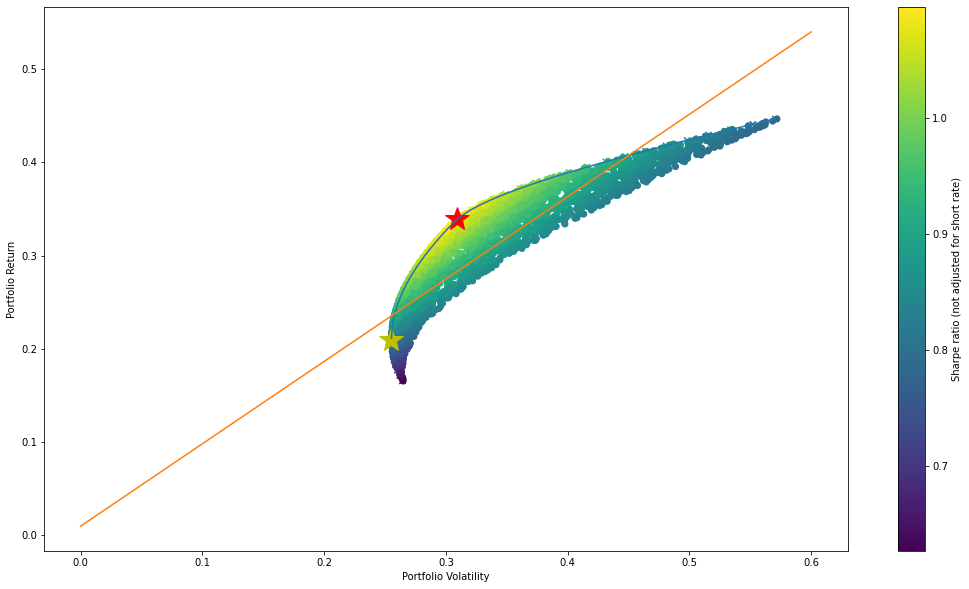

In [28]:
import matplotlib.pyplot as plt 

# initialize figure size
plt.figure(figsize=(18,10))

plt.scatter(port_vols,
            port_returns,
            c = (port_returns / port_vols),
            marker = 'o')

plt.scatter(minimal_volatilities,
            target_returns,
            c = (target_returns / minimal_volatilities),
            marker = 'x')

plt.plot(portfolio_stats(optimal_sharpe_weights)['volatility'],
         portfolio_stats(optimal_sharpe_weights)['return'],
         'r*',
         markersize = 25.0)

plt.plot(portfolio_stats(optimal_variance_weights)['volatility'],
         portfolio_stats(optimal_variance_weights)['return'],
         'y*',
         markersize = 25.0)
plt.plot(x_range, bspline)
plt.plot(cx, optimal[0] + optimal[1] * cx, lw=1.5, label='Capital Market Line') # Capital Market Line

plt.xlabel('Portfolio Volatility')
plt.ylabel('Portfolio Return')
plt.colorbar(label='Sharpe ratio (not adjusted for short rate)')

In [141]:
np.round(eqs(optimal),4)

array([ 0., -0.,  0.])

In [121]:
constraints =(
    {'type':'eq','fun': lambda x: portfolio_stats(x)['return']-func(optimal[2])},
    {'type':'eq','fun': lambda x: np.sum(x)-1},
    )

result = optimize.minimize(minimize_volatility,
                           initializer,
                           method = 'SLSQP',
                           bounds = bounds,
                           constraints = constraints)

optimal_weights = result['x'].round(3)

portfolio = list(zip(assets, list(optimal_weights)))
print(portfolio)

[('TSLA', 0.148), ('GOOG', 0.145), ('AAPL', 0.707)]
